# Benchmarks and Metrics with StudyRunner

Run multi-problem studies, compare algorithms and backends, and inspect hypervolume metrics.

This notebook covers:
1. **Algorithm comparison** - NSGA-II vs MOEA/D across problems
2. **Backend comparison** - numpy vs numba vs moocore engines
3. **Pareto front visualization** - overlay fronts from different runs
4. **Performance metrics** - HV, runtime, evaluations/sec

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vamos import ExperimentConfig
from vamos.experiment.study.runner import StudyRunner, StudyTask
from vamos.ux.analysis.tuning_viz import study_results_to_dataframe
from vamos.foundation.kernel.registry import resolve_kernel

plt.style.use("ggplot")

# Detect available backends
def detect_engines(candidates):
    engines = []
    for name in candidates:
        try:
            resolve_kernel(name)
            engines.append(name)
        except Exception as exc:
            print(f"Skipping engine '{name}': {exc}")
    return engines

AVAILABLE_ENGINES = detect_engines(["numpy", "numba", "moocore"])
if not AVAILABLE_ENGINES:
    print("No engines resolved; defaulting to numpy.")
    AVAILABLE_ENGINES = ["numpy"]

print(f"Available engines: {', '.join(AVAILABLE_ENGINES)}")


Available engines: numpy, numba, moocore


In [2]:
# Build a study grid: problems x algorithms x engines x seeds
problems = [
    {"problem": "zdt1", "n_var": 12},
    {"problem": "zdt2", "n_var": 12},
]
algorithms = ["nsgaii", "moead"]
engines = AVAILABLE_ENGINES  # include moocore when available
seeds = [0, 1]

AUTONSGAII_VARIATION = {
    "crossover": ("blx_alpha", {"prob": 0.88, "alpha": 0.94, "repair": "clip"}),
    "mutation": ("non_uniform", {"prob": "0.45/n", "perturbation": 0.3}),
    "selection": ("tournament", {"pressure": 9}),
    "repair": ("round", {}),
}

external_archive_size = 56  # external archive for algorithms that support it
archive_type = "hypervolume"

tasks = []
for prob in problems:
    for alg in algorithms:
        for engine in engines:
            for seed in seeds:
                is_nsgaii = alg == "nsgaii"
                tasks.append(
                    StudyTask(
                        algorithm=alg,
                        engine=engine,
                        problem=prob["problem"],
                        n_var=prob["n_var"],
                        seed=seed,
                        selection_pressure=9 if is_nsgaii else 2,
                        external_archive_size=external_archive_size if is_nsgaii else None,
                        archive_type=archive_type,
                        nsgaii_variation=AUTONSGAII_VARIATION if is_nsgaii else None,
                        config_overrides={
                            "population_size": 56 if is_nsgaii else 200,
                            "offspring_population_size": 14 if is_nsgaii else 200,
                            "max_evaluations": 50000,
                        },
                    )
                )

print(f"Total tasks: {len(tasks)}")
runner = StudyRunner(verbose=True)
if not tasks:
    print("No tasks to run; check engine detection.")
    results = []
    df = pd.DataFrame()
else:
    results = runner.run(tasks)
    df = study_results_to_dataframe(results)
    df.head(10)




Total tasks: 24
[Study] (1/24) nsgaii | numpy | zdt1 | seed=0
VAMOS Experiment Runner
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 12
Objectives: 2
Encoding: continuous
Algorithm: NSGAII
Backend: numpy
Population size: 200
Offspring population size: 200
Max evaluations: 50000
--------------------------------------------------------------------------------
nsgaii -> Time: 21776.90 ms | Eval/s: 2296.0
Objective 1 spread: 0.999877

Results stored in: results\ZDT1\nsgaii\numpy\seed_0
[Study] (2/24) nsgaii | numpy | zdt1 | seed=1
VAMOS Experiment Runner
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 12
Objectives: 2
Encoding: continuous
Algorithm: NSGAII
Backend: numpy
Population size: 200
Offspring population size: 200
Max evaluations: 50000
--------------------------------------------------------------------------------
nsgaii -> Time: 20304.52 ms | Eval/s: 2462.5
Object

In [3]:
# Summarize HV per algorithm/problem/engine
summary = pd.DataFrame()
if df.empty:
    print("No results to summarize yet.")
else:
    summary = df.groupby(["problem", "algorithm", "engine"]).agg({
        "hv": ["mean", "std"],
        "time_ms": ["mean"],
    }).round(4)
    summary.columns = ["hv_mean", "hv_std", "time_ms_mean"]
    summary = summary.reset_index()
    summary


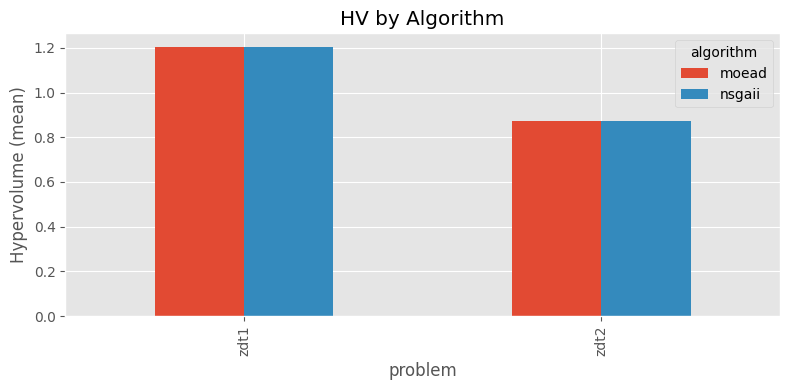

In [4]:
# HV comparison by algorithm
if df.empty:
    print("No results to plot yet.")
elif summary.empty:
    print("Summary is empty; run the study first.")
else:
    pivot_algo = summary.groupby(["problem", "algorithm"])["hv_mean"].mean().unstack()
    ax = pivot_algo.plot(kind="bar", figsize=(8, 4))
    ax.set_ylabel("Hypervolume (mean)")
    ax.set_title("HV by Algorithm")
    plt.tight_layout()
    plt.show()


## Backend Comparison

Compare performance across different kernel backends (numpy, numba, moocore).

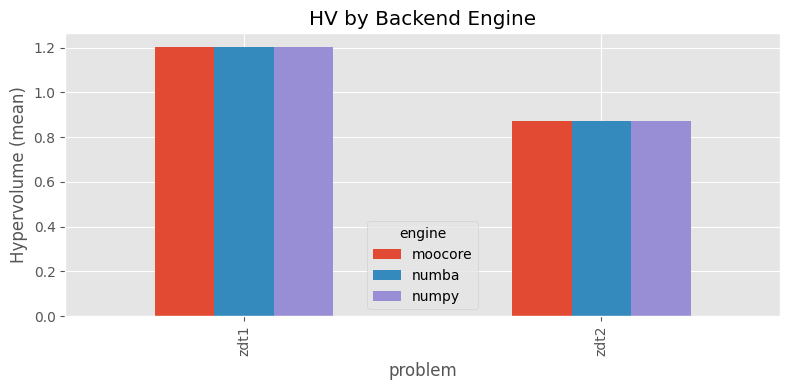

In [5]:
# HV by backend engine
if df.empty:
    print("No results to plot yet.")
elif summary.empty:
    print("Summary is empty; run the study first.")
else:
    pivot_engine = summary.groupby(["problem", "engine"])["hv_mean"].mean().unstack()
    ax = pivot_engine.plot(kind="bar", figsize=(8, 4))
    ax.set_ylabel("Hypervolume (mean)")
    ax.set_title("HV by Backend Engine")
    plt.tight_layout()
    plt.show()


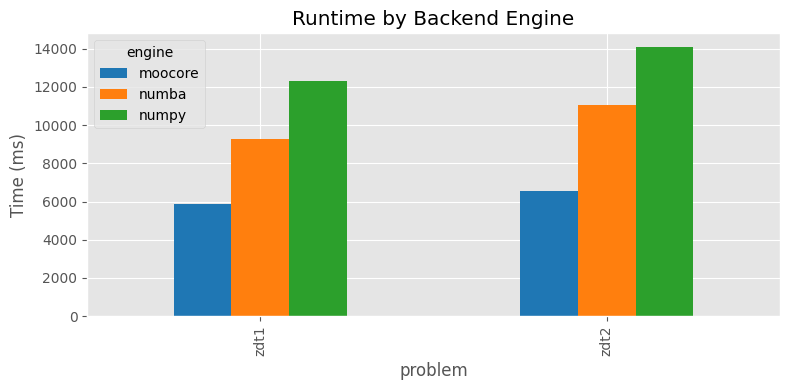

In [6]:
# Runtime comparison by backend
if df.empty:
    print("No results to plot yet.")
elif summary.empty:
    print("Summary is empty; run the study first.")
else:
    pivot_time = summary.groupby(["problem", "engine"])["time_ms_mean"].mean().unstack()
    ax = pivot_time.plot(kind="bar", figsize=(8, 4), color=['tab:blue', 'tab:orange', 'tab:green'][:len(pivot_time.columns)])
    ax.set_ylabel("Time (ms)")
    ax.set_title("Runtime by Backend Engine")
    plt.tight_layout()
    plt.show()


## Pareto Front Visualization

Overlay Pareto fronts from different engines to verify consistency.

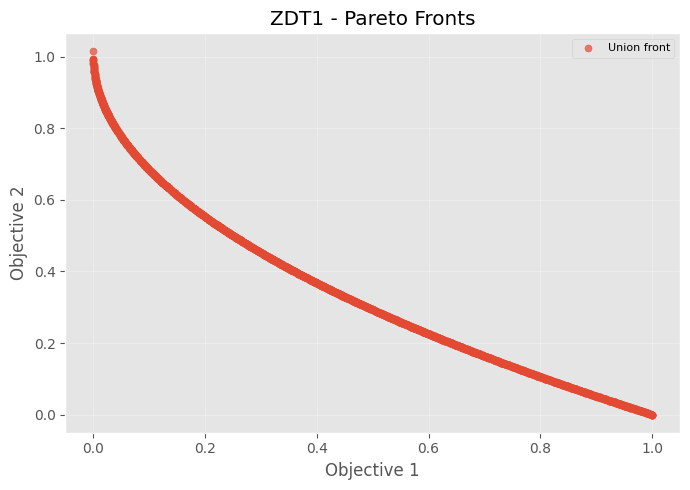

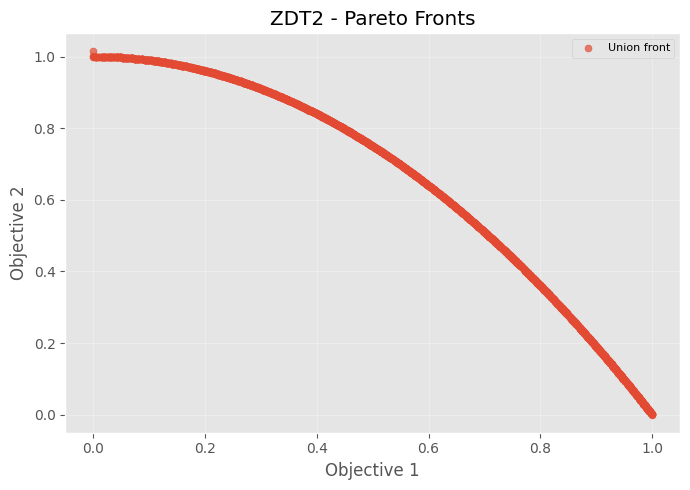

In [7]:
from vamos import pareto_filter

# Plot Pareto fronts by problem, using union non-dominated points
if not results:
    print("No results available yet. Run the study cell first.")
else:
    by_problem = {}
    for res in results:
        key = res.selection.spec.label
        by_problem.setdefault(key, []).append(res)

    for label, entries in by_problem.items():
        fig, ax = plt.subplots(figsize=(7, 5))
        fronts = []
        def _front_from_metrics(metrics):
            archive = metrics.get("archive")
            if isinstance(archive, dict):
                F_arch = archive.get("F")
                if F_arch is not None:
                    F_arch = np.asarray(F_arch)
                    if F_arch.size:
                        return F_arch
            return np.asarray(metrics["F"])
        def pareto_filter_eps(F, eps=1e-6):
            F = np.asarray(F)
            if F.size == 0:
                return F
            keep = np.ones(F.shape[0], dtype=bool)
            for i in range(F.shape[0]):
                if not keep[i]:
                    continue
                fi = F[i]
                dominated = np.all(F <= fi + eps, axis=1) & np.any(F < fi - eps, axis=1)
                keep[dominated] = False
            return F[keep]
        for res in entries:
            F = _front_from_metrics(res.metrics)
            if F.size:
                fronts.append(F)
        if not fronts:
            continue
        F_all = np.vstack(fronts)
        F_plot = pareto_filter(F_all)
        if F_plot is None or F_plot.size == 0:
            continue
        F_plot = pareto_filter_eps(F_plot, eps=1e-6)
        ax.scatter(F_plot[:, 0], F_plot[:, 1], s=25, alpha=0.7, label="Union front")

        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.set_title(f"{label} - Pareto Fronts")
        ax.legend(loc="upper right", fontsize=8)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
